In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
with open('names.txt', 'r') as fp:
    words = fp.read().splitlines()
    
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set("".join(words))))
char_to_i = {char:i+1 for i, char in enumerate(chars)}
char_to_i['.'] = 0
i_to_char = {i:s for s, i in char_to_i.items()}
print(i_to_char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
ngram = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * ngram
        for ch in w + '.':
            ix = char_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


tensor(0.0097) tensor(0.9949)
tensor(-2.0140e-05) tensor(0.9927)


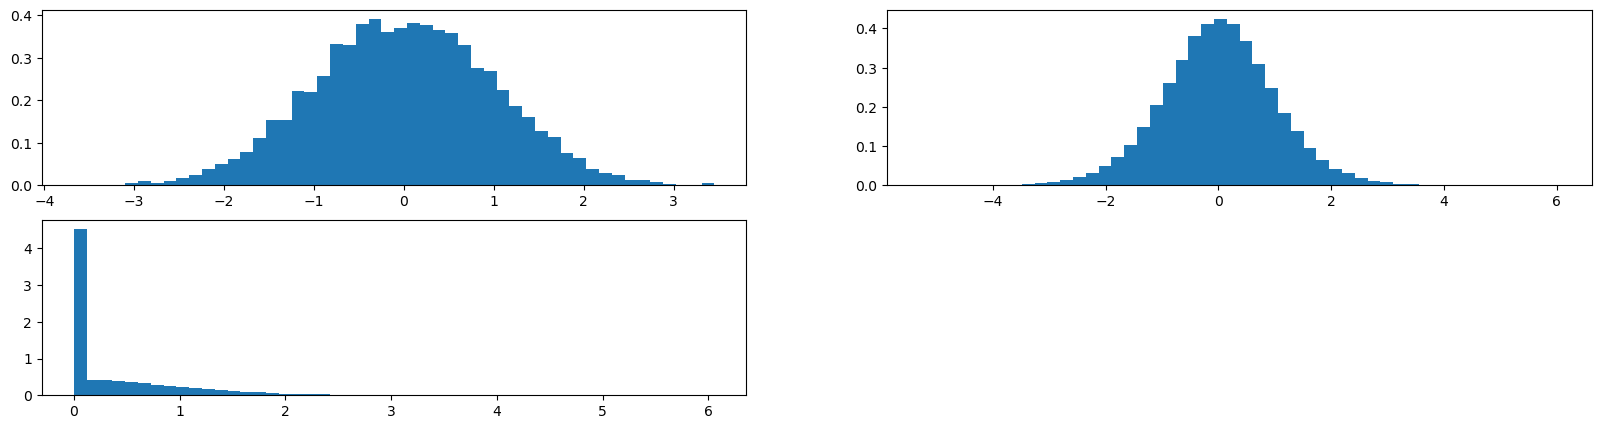

In [60]:
x = torch.randn((1000, 10))
w = torch.randn((10, 200)) / 10**0.5
h = x @ w
a = torch.relu(h)
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(221)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(222)
plt.hist(h.view(-1).tolist(), 50, density=True)
plt.subplot(223)
plt.hist(a.view(-1).tolist(), 50, density=True)
plt.show()

In [94]:
vocab_len = len(i_to_char)
embed_dim = 10
hidden_dim = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_len, embed_dim), generator=g)
W1 = torch.randn((embed_dim * ngram, hidden_dim), generator=g) * (5/3)/((embed_dim * ngram) ** 0.5)
b1 = torch.randn(hidden_dim, generator=g) * 0.01
W2 = torch.randn((hidden_dim, vocab_len), generator=g) * 0.01
b2 = torch.randn(vocab_len, generator=g) * 0

bngain = torch.ones((1, hidden_dim))
bnbias = torch.zeros((1, hidden_dim))

bnmean_running = torch.zeros((1, hidden_dim))
bnstd_running = torch.ones((1, hidden_dim))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f"num params: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

num params: 12297


In [95]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    idxs = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X, Y = X_train[idxs], Y_train[idxs]

    emb = C[X]
    emb_concat = emb.view(emb.shape[0], -1)
    h = emb_concat @ W1 + b1

    # batchnorm
    bnmeani = h.mean(0, keepdims=True)
    bnstdi = h.std(0, keepdims=True)
    h = bngain * (h - bnmeani)/(bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    a = torch.tanh(h)
    logits = a @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
        
    if i%10000 == 0:
        print(f"{i}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

0/200000: 3.3147
10000/200000: 2.1984
20000/200000: 2.3375
30000/200000: 2.4359
40000/200000: 2.0119
50000/200000: 2.2595
60000/200000: 2.4775
70000/200000: 2.1020
80000/200000: 2.2788
90000/200000: 2.1862
100000/200000: 1.9474
110000/200000: 2.3010
120000/200000: 1.9837
130000/200000: 2.4523
140000/200000: 2.3839
150000/200000: 2.1987
160000/200000: 1.9733
170000/200000: 1.8668
180000/200000: 1.9973
190000/200000: 1.8347


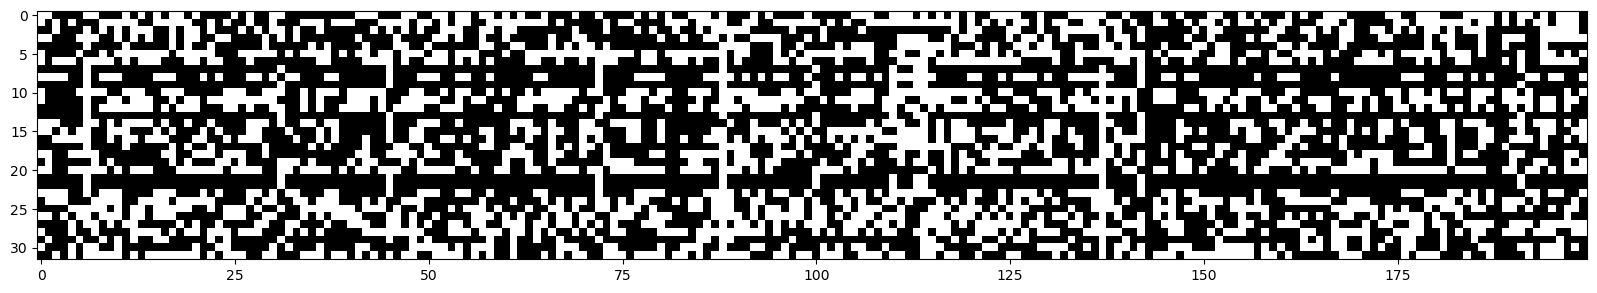

In [96]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

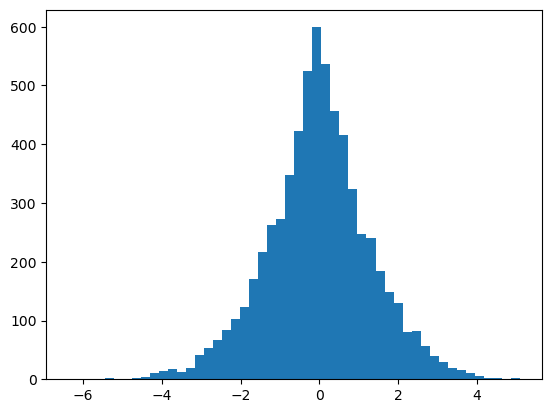

In [97]:
plt.hist(h.view(-1).tolist() , 50)
plt.show()

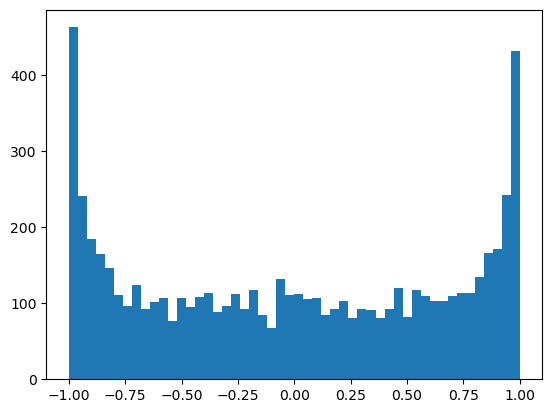

In [98]:
plt.hist(a.view(-1).tolist() , 50)
plt.show()

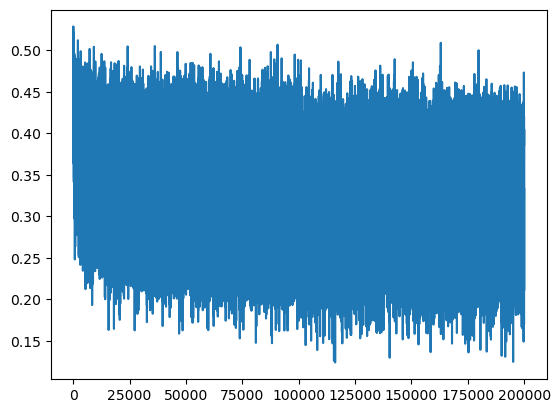

In [99]:
plt.plot(lossi)

### Dont estimate BN parameters on the training set

In [100]:
# with torch.no_grad():
#     emb = C[X_train]
#     emb_concat = emb.view(X_train.shape[0], -1)
    
#     h = emb_concat @ W1 + b1
    
#     # estimate bn parameters
#     bn_mean = h.mean(0, keepdims=True)
#     bn_std = h.std(0, keepdims=True)


### Split loss

In [101]:
@torch.no_grad()

def split_loss(split):
    X, Y = {
            'train': (X_train, Y_train),
            'dev': (X_dev, Y_dev),
            'test': (X_test, Y_test)
           }[split]

    emb = C[X]
    emb_concat = emb.view(emb.shape[0], -1)

    h = emb_concat @ W1 + b1
    # batchnorm
    h = bngain * (h - bnmean_running)/(bnstd_running) + bnbias
    
    a = torch.tanh(h)
    logits = a @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f"{split}: {loss.item(): .4f}")
    
split_loss('train')
split_loss('dev')

train:  2.0666
dev:  2.1051


### Sample

In [102]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * ngram
    while True:
        emb = C[torch.tensor(context)]
        h1 = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h1 @ W2 + b2
        # counts = logits.exp()
        # probs = counts/counts.sum(dim=1, keepdims=True)
        probs = F.softmax(logits, dim=1)
        next_idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [next_idx]
        out.append(i_to_char[next_idx])
        if next_idx == 0:
            break
    print(''.join(out))      
        
    

carpahzarbriq.
shlimrixtts.
lusslaysierricnenddhn.
frtivgqliyah.
farrichaiirdnsleggyu.
bmanvitte.
sants.
lustvi.
vabbuwatth.
giidryxiidh.
sulipsables.
falia.
gtas.
jasfaylahas.
bduricsydustquovozswy.
bjumillassannyks.
sadlusoffordst.
sramsryndlycpllmanraq.
shelseombriyabhda.
ffxrdustvebndvi.


## Torch-ify code

In [87]:
from utils import Linear, BatchNorm1d, Tanh

In [88]:
ngram = 3
vocab_len = len(i_to_char)
embed_dim = 10
hidden_dim = 100
g = torch.Generator().manual_seed(2147483647)


C = torch.randn((vocab_len, embed_dim), generator=g)

layers = [
    Linear(embed_dim * ngram, hidden_dim), 
    BatchNorm1d(hidden_dim),
    Tanh(),
    
    Linear(hidden_dim, hidden_dim), 
    BatchNorm1d(hidden_dim),
    Tanh(),
    
    Linear(hidden_dim, hidden_dim), 
    BatchNorm1d(hidden_dim),
    Tanh(),
    
    Linear(hidden_dim, hidden_dim), 
    BatchNorm1d(hidden_dim),
    Tanh(),
    
    Linear(hidden_dim, hidden_dim), 
    BatchNorm1d(hidden_dim),
    Tanh(),
    
    Linear(hidden_dim, vocab_len),
    BatchNorm1d(vocab_len),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [89]:
max_steps = 200000
batch_size = 32
lossi = []

ud = []
for i in range(max_steps):
    
    # get a minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X, Y = X_train[idxs], Y_train[idxs]
    
    # forward
    emb = C[X]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Y)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f"loss {i}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i>=1000:
        break

loss 0/200000: 3.2999


layer 2 Tanh 	 mean: 0.00 std: 0.63 saturated: 3.28%
layer 5 Tanh 	 mean: -0.00 std: 0.64 saturated: 2.62%
layer 8 Tanh 	 mean: 0.00 std: 0.65 saturated: 2.28%
layer 11 Tanh 	 mean: 0.00 std: 0.65 saturated: 2.34%
layer 14 Tanh 	 mean: 0.00 std: 0.66 saturated: 1.50%


Text(0.5, 1.0, 'activation distributions')

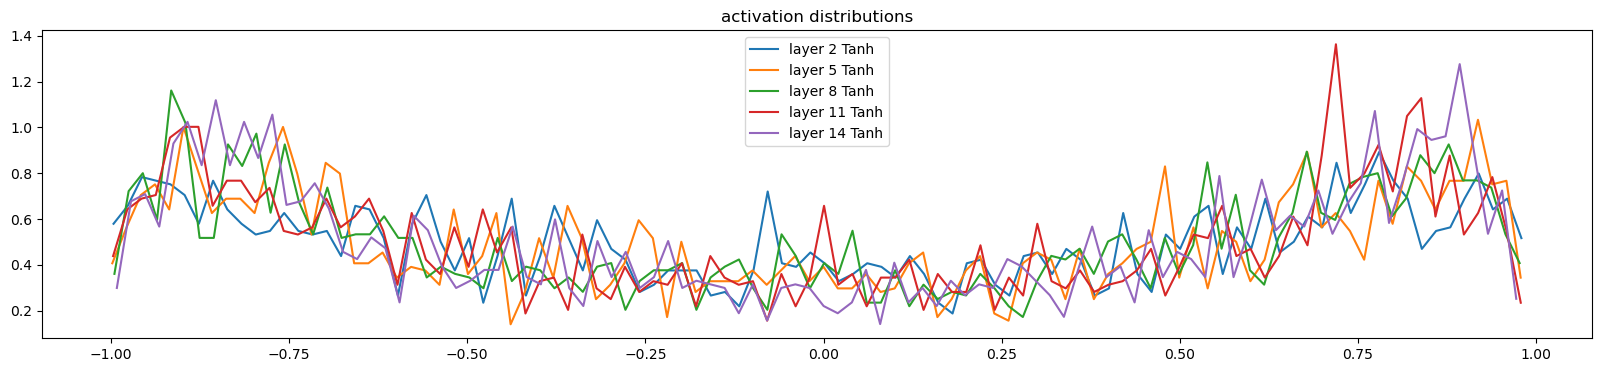

In [90]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} {layer.__class__.__name__} \t mean: {t.mean():.2f} std: {t.std():.2f} saturated: {(t.abs()>0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)

        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {layer.__class__.__name__}")
plt.legend(legends)
plt.title('activation distributions')

layer 2 Tanh 	 mean: 4.656612768993984e-12 std: 0.0023915788624435663
layer 5 Tanh 	 mean: -1.3969838306981952e-11 std: 0.0021123290061950684
layer 8 Tanh 	 mean: -6.984919153490976e-12 std: 0.0019453634740784764
layer 11 Tanh 	 mean: 0.0 std: 0.0018230362329632044
layer 14 Tanh 	 mean: 1.164153192248496e-12 std: 0.0018765865825116634


Text(0.5, 1.0, 'gradient distributions')

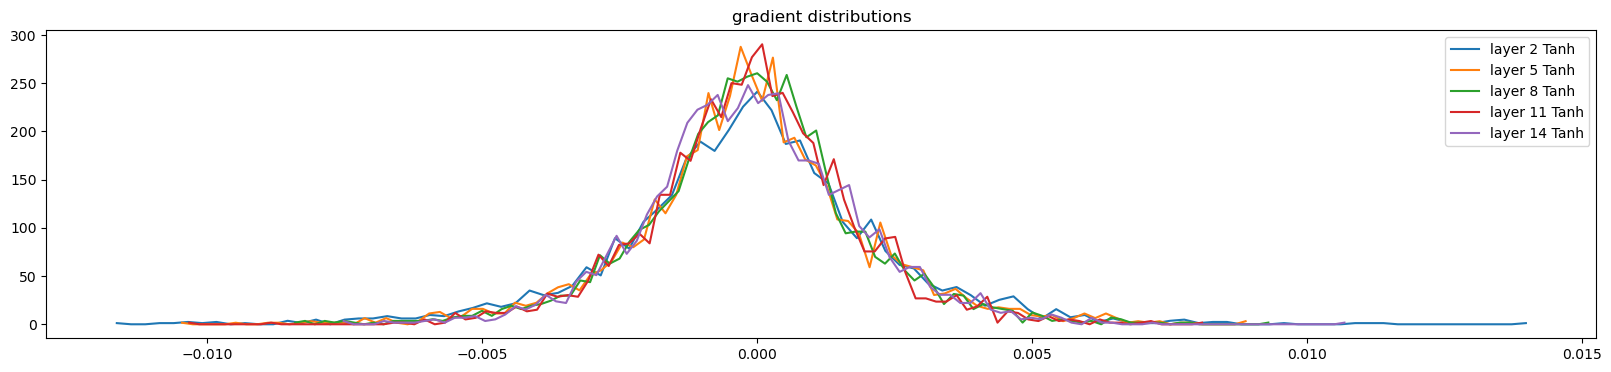

In [91]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} {layer.__class__.__name__} \t mean: {t.mean()} std: {t.std()}")
        hy, hx = torch.histogram(t, density=True)

        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {layer.__class__.__name__}")
plt.legend(legends)
plt.title('gradient distributions')

weight (27, 10)   mean: -6.898685789291648e-11 std: 0.009412955492734909 grad:data ratio 0.009403310716152191
weight (30, 100)   mean: -0.0002314115990884602 std: 0.00923012476414442 grad:data ratio 0.04967976734042168
weight (100, 100)   mean: 0.00011925173021154478 std: 0.007205793168395758 grad:data ratio 0.07002145051956177
weight (100, 100)   mean: -7.164146518334746e-05 std: 0.006181841250509024 grad:data ratio 0.05992912873625755
weight (100, 100)   mean: -2.904725624830462e-05 std: 0.0053361146710813046 grad:data ratio 0.052422866225242615
weight (100, 100)   mean: -1.0110116818395909e-05 std: 0.0049301269464194775 grad:data ratio 0.04895125702023506
weight (100, 27)   mean: -6.498041329905391e-05 std: 0.009746149182319641 grad:data ratio 0.09185784310102463


Text(0.5, 1.0, 'weights gradient distributions')

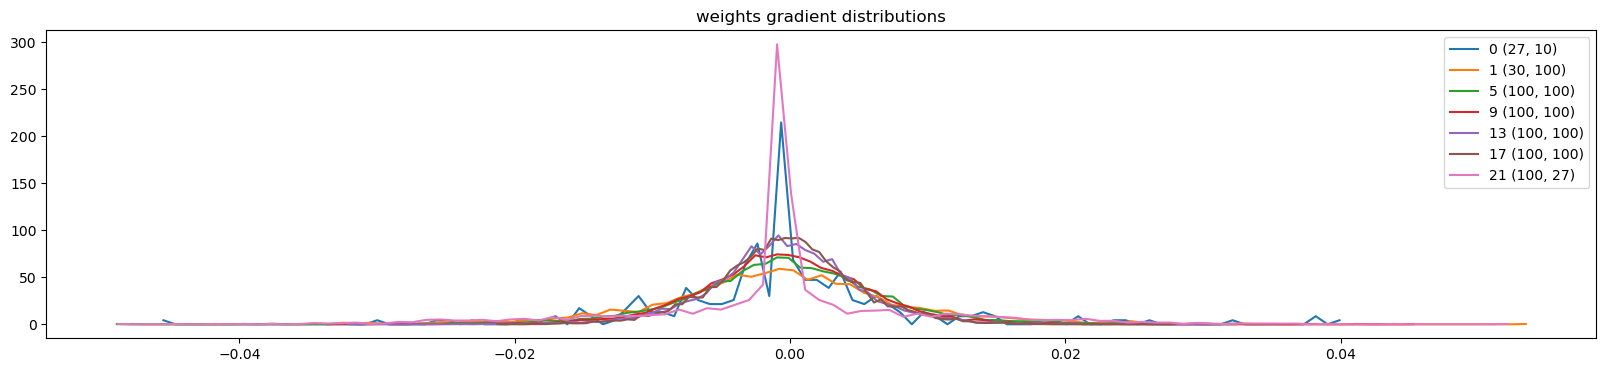

In [92]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f"weight {tuple(p.shape)}   mean: {t.mean()} std: {t.std()} grad:data ratio {t.std()/p.std()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distributions')

Text(0.5, 1.0, 'parameter update ratio')

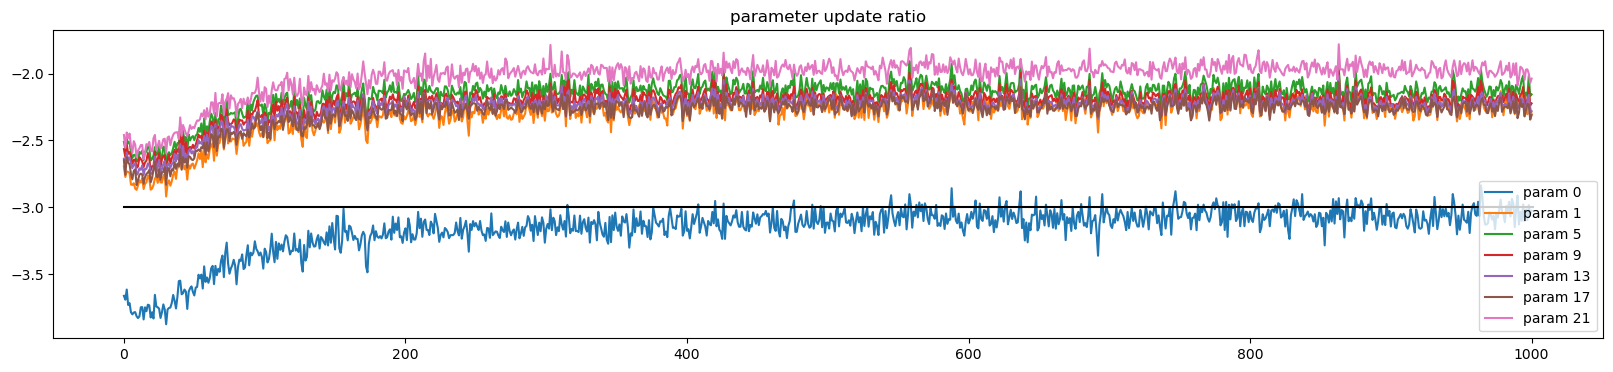

In [93]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param {i}")

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('parameter update ratio')